=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
Scaled Training Data:
 Min -2.940920352935791 Max 2.502476692199707 Mean 0.004999995231628418


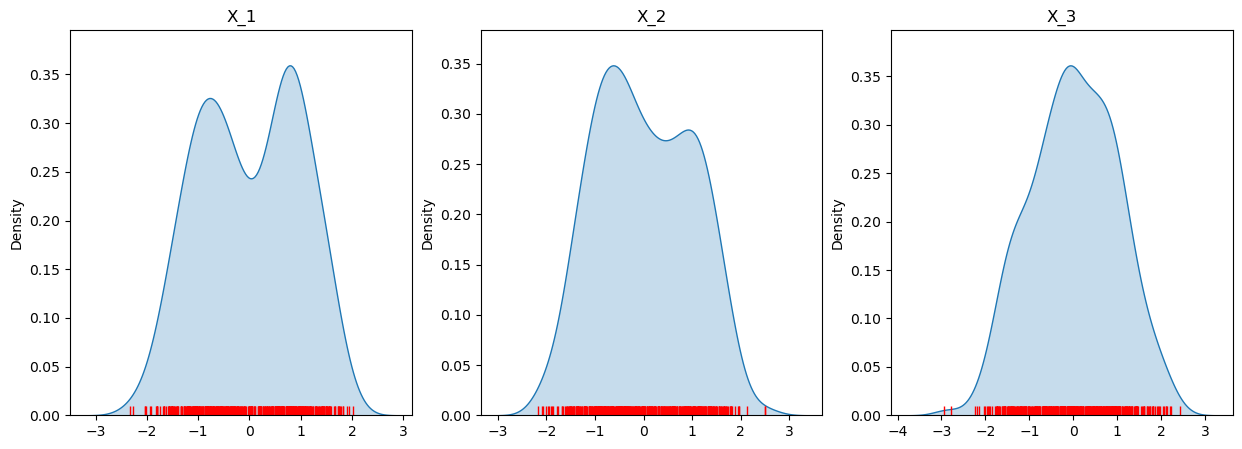

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, Input
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from cflow.masked_linear import create_masks_np, LinearMasked, create_theta_tilde_maf, dag_loss

######### DGP #########
def dgp(n_obs):
    print("=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)")
    flip = np.random.choice([0, 1], n_obs)
    X_1 = flip * np.random.normal(-2, np.sqrt(1.5), n_obs) + (1 - flip) * np.random.normal(1.5, 1, n_obs)
    X_2 = -X_1 + np.random.normal(size=n_obs)
    X_3 = X_1 + 0.25 * X_2 + np.random.normal(size=n_obs)

    dat_s = np.column_stack((X_1, X_2, X_3))
    dat_tf = tf.constant(dat_s, dtype=tf.float32)

    # Scaling the data
    scaler = StandardScaler()
    scaled = scaler.fit_transform(dat_tf.numpy()) * 0.99 + 0.005

    A = np.array([[0, 1, 1], [0, 0, 1], [0, 0, 0]])
    return {'df_orig': dat_tf, 'df_scaled': scaled, 'A': A}

# Generate training data
train = dgp(500)
# Give summary statistics of df_scaled
import seaborn as sns

# Give summary statistics of df_scaled
print(f"Scaled Training Data:\n Min {train['df_scaled'].min()} Max {train['df_scaled'].max()} Mean {train['df_scaled'].mean()}")

# Plot the KDEs of the training data
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    sns.kdeplot(train['df_scaled'][:, i], ax=axs[i], fill=True)
    sns.rugplot(train['df_scaled'][:, i], ax=axs[i], color='r')
    axs[i].set_title(f"X_{i+1}")
plt.show()

In [16]:
M = 30
# Transpose the adjacency matrix
adjacency = np.transpose(train['A']) == 1 #Needs to be a boolean matrix
# Define layer sizes
hidden_features = (2,2)
layer_sizes = (adjacency.shape[1], *hidden_features, adjacency.shape[0])
print(f"A: {adjacency}, Layer sizes: {layer_sizes}")
masks = create_masks_np(adjacency = adjacency, hidden_features=hidden_features)
param_model = create_theta_tilde_maf(adjacency=adjacency, order=M+1, layer_sizes=layer_sizes, masks=masks)
from keras.utils import plot_model
print(f"Output of untrained model {param_model(tf.constant(train['df_scaled'], dtype=tf.float32)).shape}")  
if (M<4):
    plot_model(param_model, to_file='model_graph.png', show_shapes=True)
    

A: [[False False False]
 [ True False False]
 [ True  True False]], Layer sizes: (3, 2, 2, 3)
Output of untrained model (500, 3, 31)


In [19]:
optimizer = Adam()
param_model.compile(optimizer=optimizer, loss=dag_loss)
#param_model.summary()
# Evaluate the untrained model
eval_result = param_model.evaluate(x=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                   y=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                   batch_size=32)

16/16 [==============================] - 0s 2ms/step - loss: 1.8931


In [20]:
# Fit the model
history = param_model.fit(x=tf.constant(train['df_scaled'], dtype=tf.float32), 
                          y=tf.constant(train['df_scaled'], dtype=tf.float32), 
                          epochs=500, 
                          verbose=True)

Epoch 1/500
16/16 [==============================] - 4s 5ms/step - loss: 1.8890
Epoch 2/500
16/16 [==============================] - 0s 6ms/step - loss: 1.8804
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 1.8717
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 1.8631
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 1.8544
Epoch 6/500
16/16 [==============================] - 0s 4ms/step - loss: 1.8456
Epoch 7/500
16/16 [==============================] - 0s 4ms/step - loss: 1.8365
Epoch 8/500
16/16 [==============================] - 0s 4ms/step - loss: 1.8270
Epoch 9/500
16/16 [==============================] - 0s 4ms/step - loss: 1.8167
Epoch 10/500
16/16 [==============================] - 0s 4ms/step - loss: 1.8053
Epoch 11/500
16/16 [==============================] - 0s 4ms/step - loss: 1.7932
Epoch 12/500
16/16 [==============================] - 0s 4ms/step - loss: 1.7801
Epoch 13/500
16/16 [=================

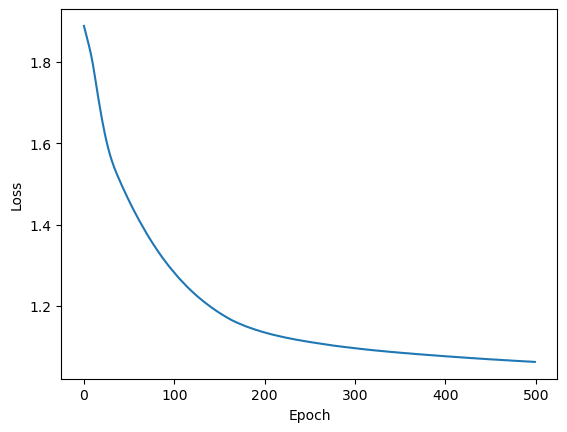

In [21]:
# Plot training history
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [23]:
eval_result = param_model.evaluate(x=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                   y=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                   batch_size=32)
print(f"Original model loss: {eval_result}")

16/16 [==============================] - 0s 2ms/step - loss: 1.0616
Original model loss: 1.061596393585205


In [26]:
# Save the model
param_model.save('triangle_test.keras')

In [28]:
# Loading the model
loaded_model = tf.keras.models.load_model(
    'triangle_test.keras', 
    custom_objects={
        'LinearMasked': LinearMasked,
        'custom_loss': dag_loss
    }
)
eval_result_loaded = loaded_model.evaluate(x=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                           y=tf.constant(train['df_scaled'], dtype=tf.float32), 
                                           batch_size=32)
print(f"Loaded model loss: {eval_result_loaded}")

16/16 [==============================] - 0s 2ms/step - loss: 1.0616
Loaded model loss: 1.061596393585205
